# Null geodesics in Kerr spacetime

In this example notebook, we want to study geodesics in the ``null`` case around a Kerr black hole, to show the capability of PyGRO to correctly reproduce known results from textbooks and also work with axisymmetric spacetimes.

Let's start by importing the necessary modules:

In [1]:
import pygro
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

# We will need to directly access and manipulate symbolic elements in the Metric object, so we import sympy
import sympy as sp

# We will solve for the critical impact parameters numerically, so we import a root findind routine from scipy
from scipy.optimize import fsolve

In [2]:
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['text.usetex'] = False
mpl.rcParams['axes.grid'] = False
mpl.rcParams['grid.color'] = "#cdcdcd"
mpl.rcParams['grid.linestyle'] = ":"
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#767afe", "#2b926c", "#b53546", "#e78b50", "#703676", "#b68ec4", "#37b4b4", "#c8c330"]) 
mpl.rcParams['font.family'] = 'cmr10'
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['axes.unicode_minus']=False

Let's define the Kerr metric in Boyer-Lindquist coordinates

$$
    ds^2 = -\left(1-\frac{2Mr}{\Sigma}\right)dt^2-\frac{4Mar\sin^2\theta}{\Sigma}dtd\phi+\frac{\Sigma}{\Delta}dr^2+\Sigma d\theta^2+\left(r^2+a^2+\frac{2Ma^2r\sin^2\theta}{\Sigma}\right)\sin^2\theta d\phi^2
$$

with $\Sigma \equiv r^2+a^2\cos^2\theta$ and $\Delta \equiv r^2-2Mr+a$. 

In the limit $M\to0$, the Kerr metric reduces to flat Minkowski space-time in oblate spheroidal coordinates, that are related to standard flat-space cartesian coordiantes via the relations $x=\sqrt{r^2+a^2}\sin\theta\cos\phi$, $y=\sqrt{r^2+a^2}\sin\theta\sin\phi$ and $z=r\cos\theta$. We will use these flat-space limit cartesian coordinates for the purpose of visualization of the geodesics resulting from our calculations. 

In [3]:
name = "Kerr spacetime"
coordinates = ["t", "r", "theta", "phi"]

transform_functions = [
    "t",
    "sqrt(r**2+a**2)*sin(theta)*cos(phi)",
    "sqrt(r**2+a**2)*sin(theta)*sin(phi)",
    "r*cos(theta)"
]

line_element = "-(1-2*M*r/(Sigma(r,theta)))*dt**2+Sigma(r,theta)/Delta(r)*dr**2+Sigma(r,theta)*dtheta**2+(r**2+a**2+2*M*r*a**2/Sigma(r,theta)*sin(theta)**2)*sin(theta)**2*dphi**2-4*M*r*a*sin(theta)**2/Sigma(r,theta)*dt*dphi"

Sigma = "r**2+a**2*cos(theta)**2"
Delta = "r**2-2*M*r+a**2"

metric = pygro.Metric(
    name = name,
    coordinates = coordinates,
    line_element = line_element,
    transform = transform_functions,
    Sigma = Sigma,
    Delta = Delta,
    M = 1,
    a = 0.5
)

(PyGRO) INFO: Initializing Kerr spacetime.
(PyGRO) INFO: Calculating inverse metric.
(PyGRO) INFO: Calculating symbolic equations of motion.
(PyGRO) INFO: Computing helper functions to normalize 4-velocity.
(PyGRO) INFO: The Metric (Kerr spacetime) has been initialized.


We have fixed the mass to unity and the spin parameter to $a=0.5$

Now we define the ``GeodesicEngine`` with a stopping criterion at the event horizon (we require that $\Delta > \epsilon$ with $\epsilon$ a small positive value).

We use in this case the RungeKutta7(8) algorithm to improve the accuracy of the integration of the unstable photon orbits (without having to reduce drastically the maximum step size)

In [4]:
geo_engine = pygro.GeodesicEngine(backend="autowrap", integrator="rkf78")
geo_engine.set_stopping_criterion("r**2-2*M*r+a**2 > 1e-4", "horizon")

(PyGRO) WARNING: No Metric object passed to the Geodesic Engine constructor. Using last initialized Metric (Kerr spacetime) instead.
(PyGRO) INFO: Linking Kerr spacetime to the Geodesic Engine
(PyGRO) INFO: Metric linking complete.


We now want to assign initial conditions to null `Geodesics` on the equatorial plane (for simplicity) of the Kerr spacetime. On this plane, one can uniquely assign initial conditions to null geodesics at a given point by defining an impact parameter

$$
    b\equiv \frac{L}{E}
$$

where $L$ and $E$ are the azimuthal angular momentum and specific energy, respectively, defined by

$$
  E = -\frac{\partial \mathcal{L}}{\partial \dot{t}},\qquad L = \frac{\partial \mathcal{L}}{\partial \dot{\phi}},
$$

with $\mathcal{L}$ being the test particle lagrangian. These quantities can be easly defined in PyGRO with:


In [5]:
L_eq = metric.subs_functions(metric.Lagrangian()).subs({'theta': sp.pi/2, 'u_theta': 0}) # We are computing the lagrangian on the equatorial plane

E = -L_eq.diff(metric.u[0])
L = L_eq.diff(metric.u[3])

b = sp.simplify(L/E)

An interesting classical result of geodesic motion in the Kerr space-time that we want to recover in PyGRO is the existence of critical impact parameters $b_c$ on the equatorial plane for which the null geodesic results in an unstable photon orbit. The critical impact parameter $b_c$ satisfies the equation
$$
    (b_c+a)^3=27M^2(b_c-a),
$$
for any given value of $a$. For $a=0$ (non-rotating case) the only solution is $b_c=\sqrt{27}M$ which corresponds to the circular photon orbit wit $r=3M$ that we have obtained in Section \ref{sec:photon_orbit} for the Schwarzschild case. For $0<a<1$, due to frame dragging, the equation has two solutions, $b_{c,\pm}$ with opposite signs, one ($b_{c,+}$) for prograde (null geodesics with $L$ having the same sign of $a$) and the other ($b_{c,-}$) for retrograde (with $L$ and $a$ having opposite signs) null geodesics. This means that there exist two different circular photon orbits on the equatorial plane at radii
$$
    r_\pm = 2M\left[1+\cos\left(\frac{2}{3}\arccos\frac{\pm a}{M}\right)\right].
$$
Null geodesics with $b_{c,-}<b<b_{c,+}$ will be bound to the central black hole and cross the event horizon. Null geodesics with impact parameter outside this interval will escape to infinity. Null geodesics with $b_{c,\pm}$ will approach asymptotically the unstable circular orbits.

Let's define a function to solve numerically for $b_c$ given the value of $a$ defined in the `Metric` object and for the two possible directions. We use as initial guess $\pm\sqrt{27}M$ (i.e. the critical impact parameter for the Schwarzschild case) and use the `scipy` function `fsolce` to obtain the value of $b_c$ numerically.

In [6]:
def get_b_c(prograde = True):
    return float(fsolve(lambda b, a: (b+a)**3-27*(b-a), (1 if prograde else -1)*np.sqrt(27), args=(metric.get_constant('a'),))[0])

Now we define a function that initializes a null geodesic on the equatorial plane, given a value of the impact parameter $b_0$

In [7]:
def get_geo_from_b(b_0, r):
    
    u_t_0 = 1
    u_phi_0 = float(metric.evaluate_parameters(sp.solve((b-b_0).subs({'u_t': u_t_0, 'r': r}), metric.u[3])[0]))
    u_r_0 = float(metric.evaluate_parameters(sp.solve(L_eq.subs({'u_t': u_t_0, 'u_phi': u_phi_0, 'r': r}), metric.u[1])[1]))
    
    geo = pygro.Geodesic("null", geo_engine)
    
    geo.initial_x = [0, r, np.pi/2, 0]
    geo.initial_u = [u_t_0, u_r_0, 0, u_phi_0]
    
    return geo

The function assumes, without loss of generality, that $\dot{t}(0)=1$ and uses the definitions of $b$ and $\mathcal{L}$ to solve for the unknown values of $\dot{\phi}(0)$ and $\dot{r}(0)$, then initializes the null geodesic with these values.


Let's now define a bunch of geodesics starting far away from the observer, e.g. $r_0=10^3$ and scan several values of the impact parameter.

For example, let's consider 20 null geodesics between the two critical impact parameters (called in the code `b_c_retro` and `b_c_pro`, respectively) and let's define an array of 60 geodesics including the critical ones, the 20 between the critical values and with the remaining ones with impact parameters outside the critical interval.

We integrate these geodesics backward in time for a time that is slightly larger than $r_0$ (in geometrized units) so that the photons can reach the central black hole and also escape (if they can).

We reduce the value of the maximum step size of the integration in correspondence with the critical values to appropriately recover the unstable circular photon orbits:

In [8]:
b_c_retro = get_b_c(prograde=False)
b_c_pro = get_b_c(prograde=True)

k = 20
n = 19

db = (b_c_pro-b_c_retro)/n

b_arr = np.linspace(b_c_retro-k*db, b_c_pro+k*db, 2*k+n+1)
b_arr[k] = b_c_retro
b_arr[k+n] = b_c_pro

geo_arr = []

for i, b_i in enumerate(b_arr):
    print(f"{i+1}/{len(b_arr)} (b = {b_i:.2f})", end="\r")
    geo = get_geo_from_b(b_i, 1000)
    geo_engine.integrate(geo, 1030, 1, accuracy_goal = 16, precision_goal= 16, hmax = .1 if b_i in [b_c_retro, b_c_pro] else np.inf,direction="bw")
    geo_arr.append(geo)

We can finally visualize the results on the equatorial plane

(PyGRO) WARNING: Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
(PyGRO) WARNING: Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


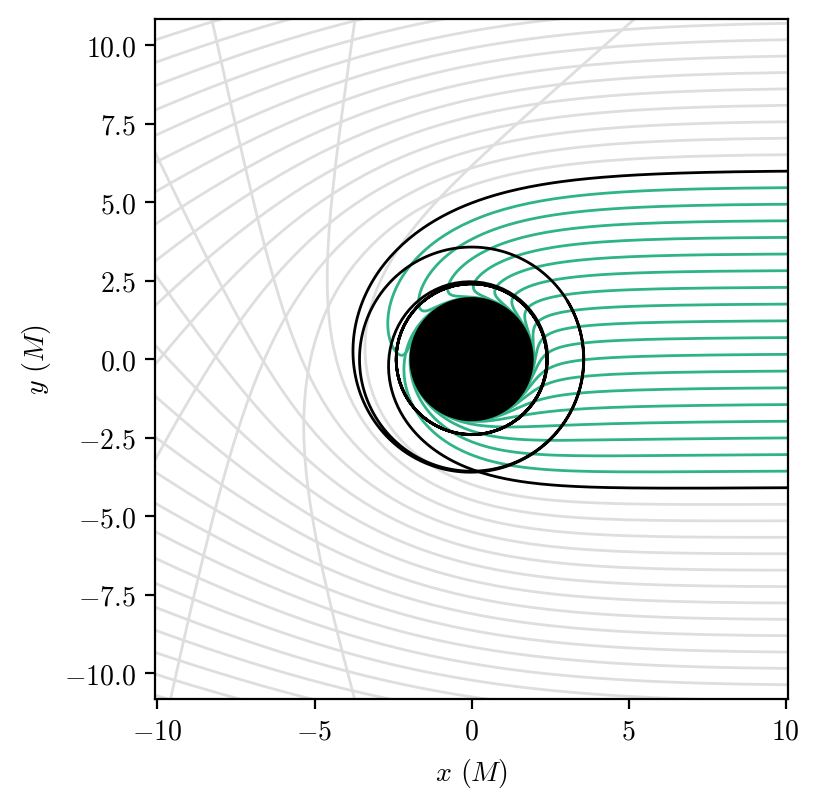

In [9]:
plt.close('all')

fig, ax = plt.subplots(figsize = (4.2, 4.2))

for b_i, geo in zip(b_arr, geo_arr):
    if b_i in [b_c_pro, b_c_retro]:
        color = "k"
    elif b_c_retro < b_i < b_c_pro:
        color = "#2fb389"
    else:
        color = "#dedede"
    t, x, y, z = metric.transform(geo.x.T)
    ax.plot(x, y, linewidth = 1, color = color, zorder = 1000 if b_i in [b_c_retro, b_c_pro] else 1)

    
r_H = (2+np.sqrt(4-4*metric.get_constant('a')**2))/2
theta = np.linspace(0, 2*np.pi, 150)
x_bh = np.sqrt(r_H**2+metric.get_constant('a')**2)*np.cos(theta)
y_bh = np.sqrt(r_H**2+metric.get_constant('a')**2)*np.sin(theta)
ax.fill(x_bh, y_bh, color = "k")

ax.axis('equal')

lim = 10

ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)

ax.set_xlabel('$x$ ($M$)')
ax.set_ylabel('$y$ ($M$)')

fig.tight_layout()


As expected theoretically, photons with $b_{c,-}<b<b_{c,+}$ (green lines) cross the horizon, while the others (gray lines) escape to infinity. Geodesics with impact parameter matching the critical values (black lines) approach the unstable circular orbits for the prograde and retrograde cases. The asymmetry of the region corresponding to bound photons with respect to a photon initially aligned with the central black hole ($b=0$) ultimately causes the asymmetry of the Kerr shadow.